# Translation of text in images using Amazon Textract and Translate

Lets start by importing some libraries will be using later

In [65]:
import boto3
import json
import logging
from botocore.exceptions import ClientError
from PIL import Image
import io
from PIL import Image, ImageDraw, ImageFont

Next we setup the clients for Textract and Translate 

In [111]:
textract_client = boto3.client('textract')
translate_client = boto3.client('translate')
logger = logging.getLogger(__name__)
# Setup a language to font filename dict
font_lookup = {"zh":"NotoSansSC-STYLE.otf",
               "ur":"NotoSansArabic-STYLE.ttf",
               "ar":"NotoSansArabic-STYLE.ttf",
              "ru":"NotoSans-STYLE.ttf",
              "ko":"NotoSansKR-STYLE.otf",
              "sq":"NotoSans-STYLE.ttf",
              "ro":"NotoSans-STYLE.ttf",
              "es":"NotoSans-STYLE.ttf"}

In [68]:
filename = 'ny_school_image_flyer.png'

In [69]:
def Sort_Tuple(tup):
    # Convenience function to sort tuple list in descending order
    # Returns: sorted tuple list
    tup.sort(key = lambda x: x[0],reverse=True)
    return tup

def text_foreground_background_color(img,bb):
    """
    Function to analyze the image and bounding box to find background
    and foreground colors and also the pixel saturation to indicate whether text 
    is bold or regular

    :param img: Input image of the page
    :param document_bytes: Bounding box coordinates
    
    :return: 
            bg_entry: Background color and pixel count
            freq_entry: Foreground color and pixel count
            bg_fg_ratio: Background to Foreground color pixel ratio from image processing
            calc_val: Background to Foreground color pixel ratio from frequency
            background_color: Alternate method for Background color using pixel offset
    """ 
    img_crop = img.crop(bb)
    background_color = img.getpixel((bb[0]-5, bb[1]-5))
    color_freq = img_crop.getcolors(img.size[0]*img.size[1]) 
    sorted_color_freq = Sort_Tuple(color_freq)
    bg_val = -1
    bg_entry = None
    
    im2 = img_crop.convert('P',palette=Image.Palette.ADAPTIVE, colors=2)
    bg_fg_stats = im2.getcolors(im2.size[0]*im2.size[1])
    
    if bg_fg_stats[1][0] < bg_fg_stats[0][0]:
        bg_fg_ratio = int(bg_fg_stats[1][0]/bg_fg_stats[0][0]*100)
    else:
        bg_fg_ratio = int(bg_fg_stats[0][0]/bg_fg_stats[1][0]*100)
        
    for freq_entry in sorted_color_freq:
        count, (r,g,b) = freq_entry
        col_total = r+g+b
        if bg_val < 0:
            bg_val = col_total
            bg_entry = freq_entry
        else:
            if abs(bg_val - col_total) > 10:
                calc_val = int(int(freq_entry[0])/int(bg_entry[0])*100)
                return bg_entry, freq_entry, bg_fg_ratio, calc_val, background_color

def detect_file_text(document_file_name=None, document_bytes=None, confidence=98.0):
    """
    Detects text elements in a local image file or from in-memory byte data.
    The image must be in PNG or JPG format.

    :param document_file_name: The name of a document image file.
    :param document_bytes: In-memory byte data of a document image.
    :param confidence: Confidence value to filter out textract response
    
    :return: A response similar from Amazon Textract, with text attributes like 
            foreground/background color and hints on text style.
    """
    if document_file_name is not None:
        with open(document_file_name, 'rb') as document_file:
            document_bytes = document_file.read()
            im = Image.open(io.BytesIO(document_bytes))
            width, height = im.size
            print(f"Image size {width}x{height}")
    try:
        response = textract_client.detect_document_text(
            Document={'Bytes': document_bytes})
        logger.info(
            "Detected %s blocks.", len(response['Blocks']))
    except ClientError:
        logger.exception("Couldn't detect text.")
        raise

    text_details = []
    for elem in response['Blocks']:
        detail = {}
        if elem['BlockType'] == "LINE":
            text_length = len(elem['Text'])
            detail['text'] = elem['Text']
            bb = elem['Geometry']['BoundingBox']
            x1 = int(float(bb['Left'])*width)
            y1 = int(float(bb['Top'])*height)
            x2 = int(float(bb['Width'])*width)+x1
            y2 = int(float(bb['Height'])*height)+y1
            detail['bb'] = (x1,y1,x2,y2) # Absolute coordinates for the bounding box
            detail['bbraw'] = bb # Coordinates as provided from Textract
            detail['Confidence']= elem['Confidence']
            #img_box = im.crop(detail['bb'])
            bg,fg, ratio, calc_val, bgcol = text_foreground_background_color(im, (x1,y1,x2,y2))
            detail['bg_color'] = bg
            detail['fg_color'] = fg
            detail['ratio'] = ratio/text_length
            detail['bg_other'] = bgcol
            detail['calc_ratio'] = calc_val/text_length
            if float(elem['Confidence']) >= confidence:
                text_details.append(detail)
    return text_details, im
            
            


In [70]:
textract_response, image = detect_file_text(document_file_name=filename)

Image size 1058x1046


In [71]:
def blank_out_text(response, img):
    """
    Blanks out all of the text from the image using the detected background color
    for each line of text

    :param response: The augented Textract response
    :param img: In-memory byte data of a document image.
    
    :return: 
        img_rgb: Blanked out image
    """
    img_rgb = img.convert("RGB")
    pad = 2
    for entry in response:
        bb = entry['bb']
        shape = [(bb[0] - pad, bb[1] - pad), (bb[2] + pad, bb[3] + pad)]
        fill = entry['bg_other'] + (255,)
        img1 = ImageDraw.Draw(img_rgb)  
        img1.rectangle(shape, fill =fill)
        img_rgb.show()
    return img_rgb


In [72]:
blanked_image = blank_out_text(textract_response, image)

In [103]:
def write_line(img, translated_text, lang, entry):
    """
    Writes a line of translated text making sure to use the correct font size
    to fit the bounding box

    :param img: In-memory byte data of a document image.
    :param translated_text: The translated text
    :param lang: Target Language
    :param entry: The augented textract response for the text line
    
    :return: 
        No specific return. The image in img is modified inline
    """
    ratio = entry['calc_ratio']
    count, text_color = entry['fg_color']
    (x1, y1, x2, y2) = entry['bb']
    box = entry['bb']
    img1 = ImageDraw.Draw(img)
    font_prefix=font_lookup[lang]
    if ratio >= 0.2:
        font_name = font_prefix.replace("STYLE","Bold")
    else:
        font_name = font_prefix.replace("STYLE","Regular")
    font_size = 300 # Starting font size
    size = None
    while (size is None or 
           size[2] >= box[2]  or 
           size[3] >= box[3]) and font_size > 0:
        # Set font and size
        #print(f"Loading font fonts/{font_name}")
        font = ImageFont.truetype(f"fonts/{font_name}", font_size)
        # Get the resulting size of the translated text at the current font size
        size = img1.multiline_textbbox(xy=[x1,y1],text=translated_text, font=font)
        if font_size > 60:
            font_diff = 10
        else:
            font_diff = 1
        # Reduce font size
        font_size -= font_diff

    # Now write the translated text to the image using the color and font to the 
    # bounding box
    img1.multiline_text((box[0], box[1]), translated_text, text_color, font)
    # Save the changes to the image
    img.show()

def draw_text(response, image, lang):
    """
    Translates all of the text and then applies it to the blanked image one line at a 
    time

    :param response: The translated text
    :param image: In-memory byte data of a document image.
    :param lang: Target Language

    :return: 
        No specific return. The image in image is modified inline
    """    

    buffer = ""
    # Construct a string with the text to send to Translate. Make efficient use 
    # of Translate calls
    # TODO: Iterate through the total text in batches if total text exceeds Translate
    # max size for synch call
    for entry in response:
        buffer += entry['text'] + '\n'
    translated_text = translate_client.translate_text(Text=buffer,
                               SourceLanguageCode="auto",
                               TargetLanguageCode=lang)
    translated_list = translated_text['TranslatedText'].split('\n')
    for index, entry in enumerate(response):
        #print(entry)
        write_line(image, translated_list[index], lang, entry)


In [104]:
tmp_image = blanked_image.copy()

In [105]:
draw_text(textract_response, tmp_image, "ur")

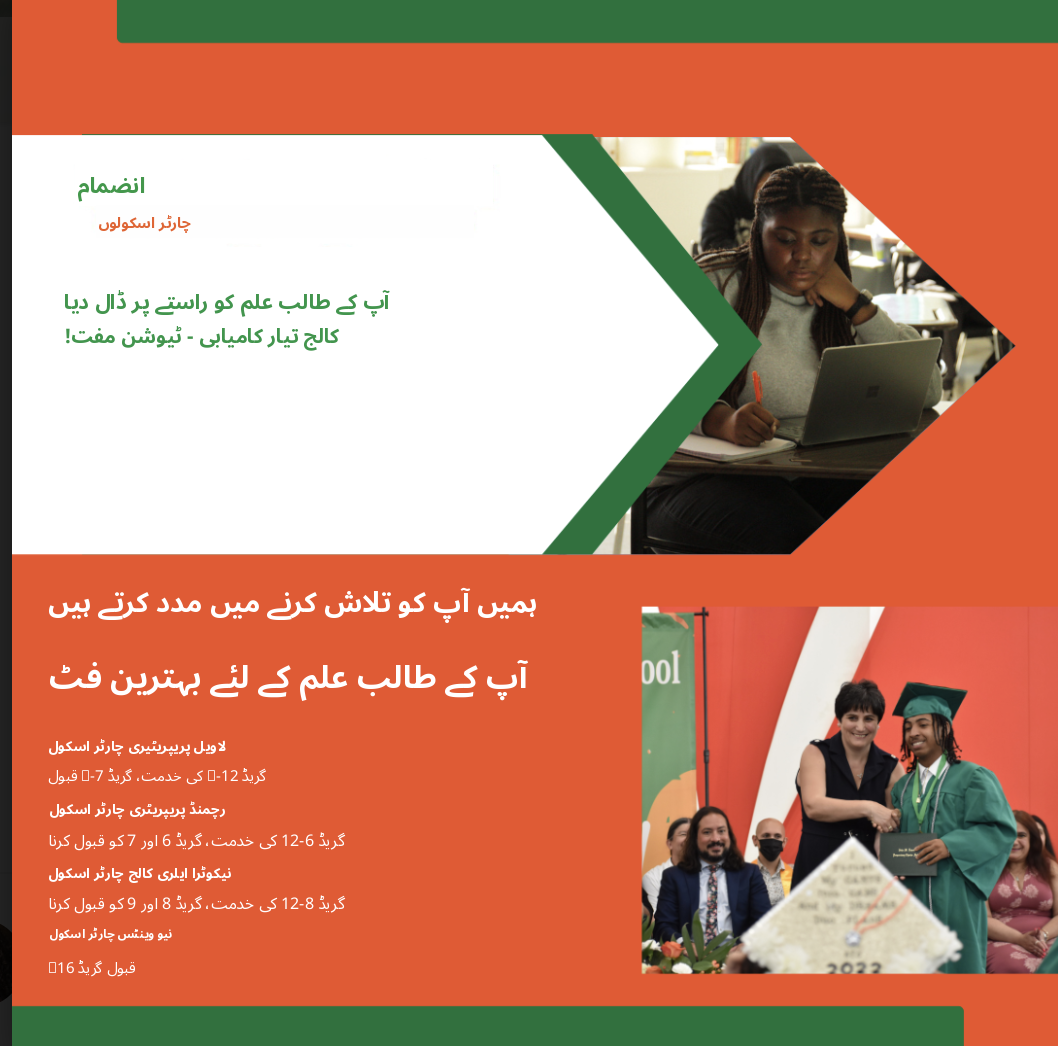

In [106]:
tmp_image

In [99]:
tmp_image = blanked_image.copy()

In [100]:
opimg = draw_text(textract_response, tmp_image, "es")

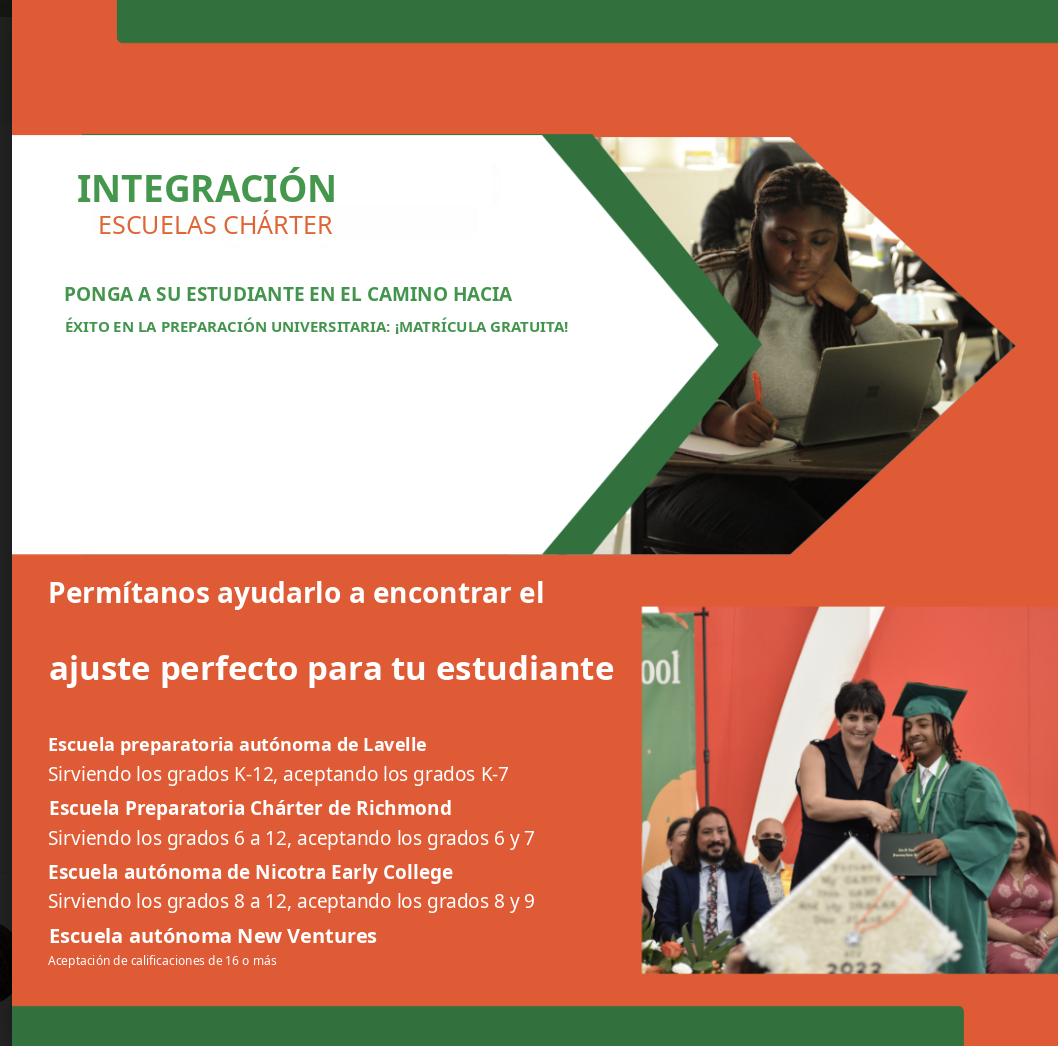

In [101]:
tmp_image

In [112]:
tmp_image = blanked_image.copy()

In [113]:
opimg = draw_text(textract_response, tmp_image, "ko")

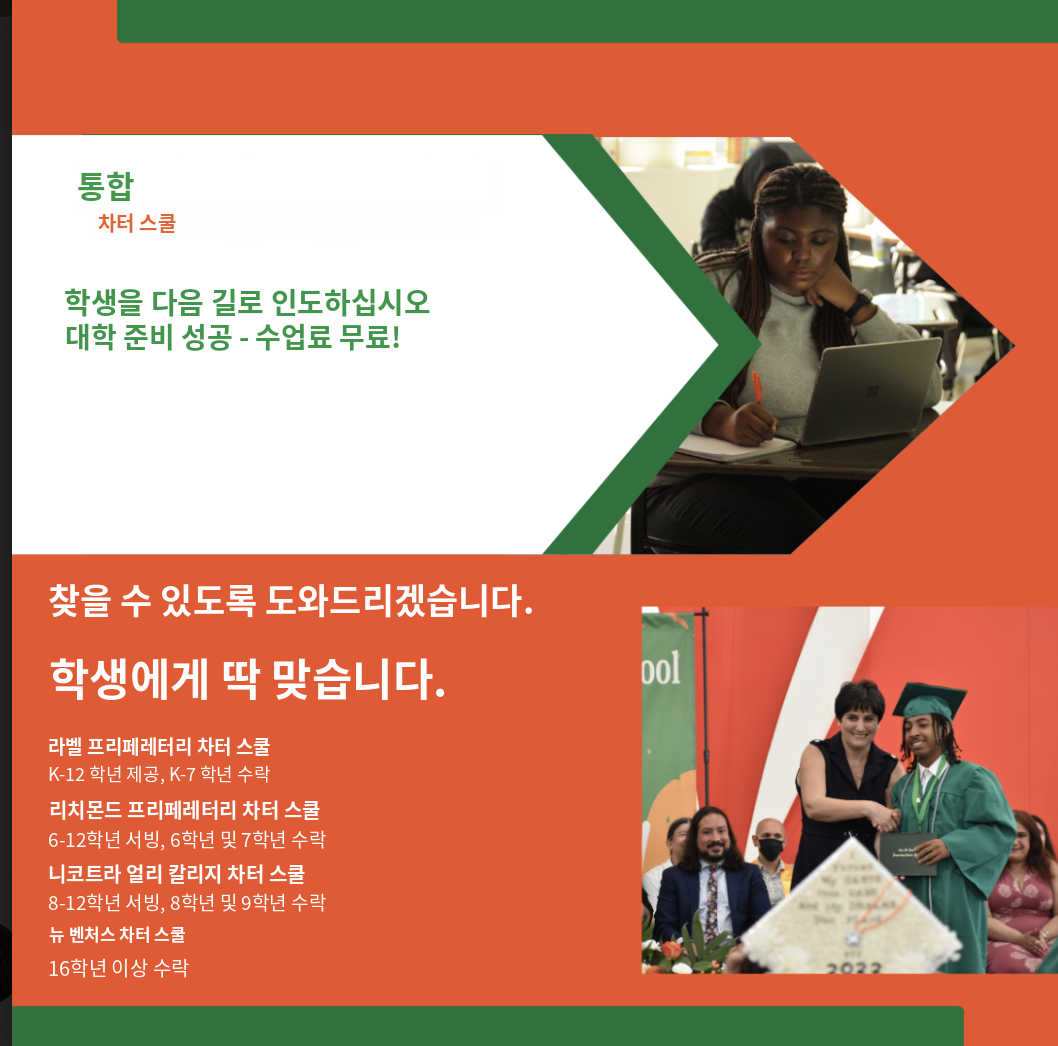

In [114]:
tmp_image